In [59]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [60]:
# Parameters.
x_dimension = 3
y_dimension = 3
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 2
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [61]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [62]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 1296
Eigenvalues: [-10.645 -10.633 -10.633 -10.633 -10.633 -10.628 -10.628 -10.503]


In [ ]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

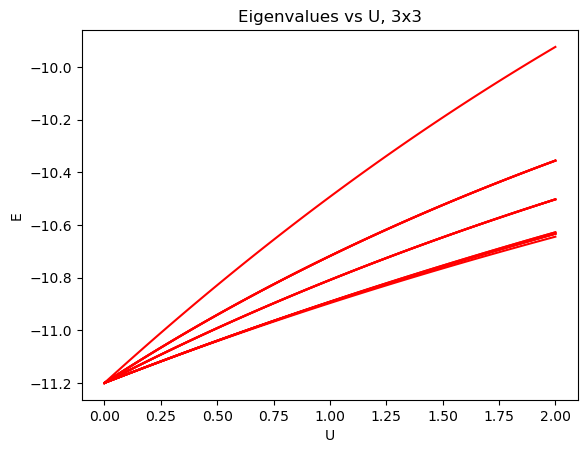

In [ ]:
for band in range(16):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [ ]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-11.2 -11.2 -11.2 -11.2 -11.2 -11.2 -11.2 -11.2]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:1])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [16, 32, 16, 48, 176, 176, 36, 48, 192, 328, 192, 36]
Number of degerate Eigenvalues:
 [16]
Eigenvalues of first Hi: 
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.44444444 0.44444444 0.44444444 0.44444444 0.55555556
 0.55555556 0.55555556 0.55555556 0.77777778]


In [10]:
k = 7
H0_eigvecs_updated = H0_eigvecs_updated[:, :k]
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

In [11]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [12]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [13]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [14]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

## Eigenbranches (error $ = 10^{-3}$)

In [15]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [16]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 100
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [17]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement_qsp(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

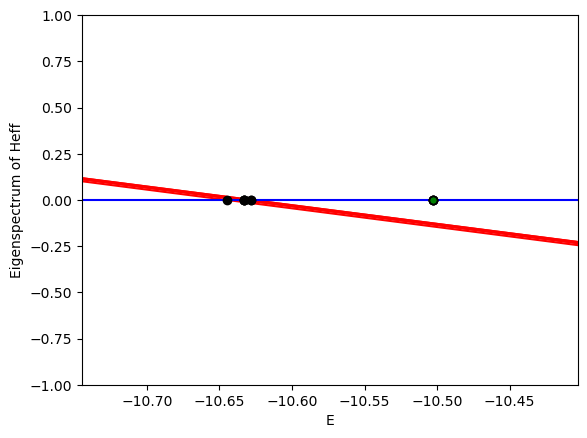

In [ ]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-1, 1)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

# Binary search 
### ($\Delta U = 0.2$)

## error $ = 10^{-3}$

In [19]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [20]:
U_sweep = jnp.linspace(0, U, 11)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 6 iterations.
-11.135143044528167
Converged in 6 iterations.
-11.134932376931712
Converged in 6 iterations.
-11.134932376931697
Converged in 6 iterations.
-11.134932376931694
Converged in 6 iterations.
-11.134932376931676
Converged in 6 iterations.
-11.134875448136118
Converged in 6 iterations.
-11.134875448136107
solve: 2
Converged in 5 iterations.
-11.072757579008687
Converged in 5 iterations.
-11.071972162186695
Converged in 5 iterations.
-11.07197216218668
Converged in 5 iterations.
-11.071972162186677
Converged in 5 iterations.
-11.071972162186661
Converged in 5 iterations.
-11.071749523518264
Converged in 5 iterations.
-11.071749523518253
solve: 3
Converged in 5 iterations.
-11.012234698001443
Converged in 5 iterations.
-11.01057423711447
Converged in 5 iterations.
-11.010574237114454
Converged in 5 iterations.
-11.01057423711445
Converged in 5 iterations.
-11.010574237114435
Converged in 5 iterations.
-11.010081320138138
Converged in 5 iterations.
-11.01008

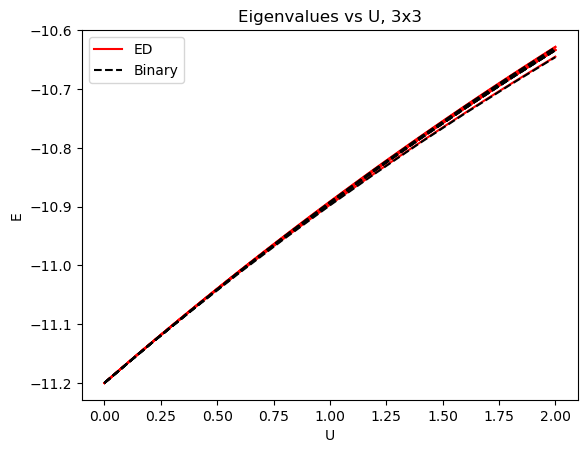

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-0.0008644729402540463
-0.0004092350662059374
-0.0004092350661899502
-0.00040923506618817385
-0.000409235066173963
-0.0008375854038416009
-0.0008375854038344954


## error $ = 10^{-6}$

In [24]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [25]:
U_sweep = jnp.linspace(0, U, 11)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 15 iterations.
-11.134634164389887
Converged in 15 iterations.
-11.134425042175273
Converged in 15 iterations.
-11.134425042175257
Converged in 15 iterations.
-11.134425042175252
Converged in 15 iterations.
-11.134425042175238
Converged in 15 iterations.
-11.134363640640007
Converged in 15 iterations.
-11.134363640639997
solve: 2
Converged in 15 iterations.
-11.071772525987672
Converged in 15 iterations.
-11.07099058821996
Converged in 15 iterations.
-11.070990588219946
Converged in 15 iterations.
-11.070990588219942
Converged in 15 iterations.
-11.070990588219926
Converged in 15 iterations.
-11.070749557013563
Converged in 15 iterations.
-11.070749557013556
solve: 3
Converged in 15 iterations.
-11.011281987560707
Converged in 15 iterations.
-11.009637068298169
Converged in 15 iterations.
-11.009637068298154
Converged in 15 iterations.
-11.00963706829815
Converged in 15 iterations.
-11.009637068298133
Converged in 15 iterations.
-11.009105196761332
Converged in 15

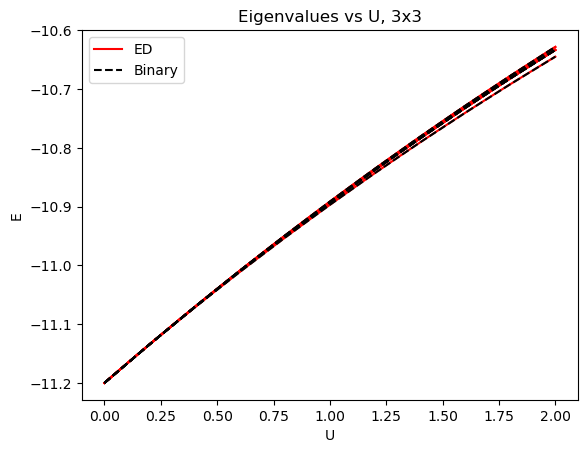

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-4.6062985603612105e-07
3.706812623782696e-05
3.706812625381417e-05
3.706812625559053e-05
3.706812627157774e-05
-5.649639156501962e-08
-5.6496384459592264e-08


## error $ = 10^{-8}$

In [29]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [30]:
U_sweep = jnp.linspace(0, U, 11)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 22 iterations.
-11.134633180297701
Converged in 22 iterations.
-11.134424023642552
Converged in 22 iterations.
-11.134424023642538
Converged in 22 iterations.
-11.134424023642532
Converged in 22 iterations.
-11.134424023642516
Converged in 22 iterations.
-11.134362650841705
Converged in 22 iterations.
-11.134362650841695
solve: 2
Converged in 22 iterations.
-11.071771597378678
Converged in 22 iterations.
-11.07098942693045
Converged in 22 iterations.
-11.070989426930435
Converged in 22 iterations.
-11.070989426930431
Converged in 22 iterations.
-11.070989426930414
Converged in 22 iterations.
-11.070748608445708
Converged in 22 iterations.
-11.070748608445701
solve: 3
Converged in 22 iterations.
-11.011281122746563
Converged in 22 iterations.
-11.009635357604036
Converged in 22 iterations.
-11.00963535760402
Converged in 22 iterations.
-11.009635357604019
Converged in 22 iterations.
-11.009635357604001
Converged in 22 iterations.
-11.00910429127715
Converged in 22 

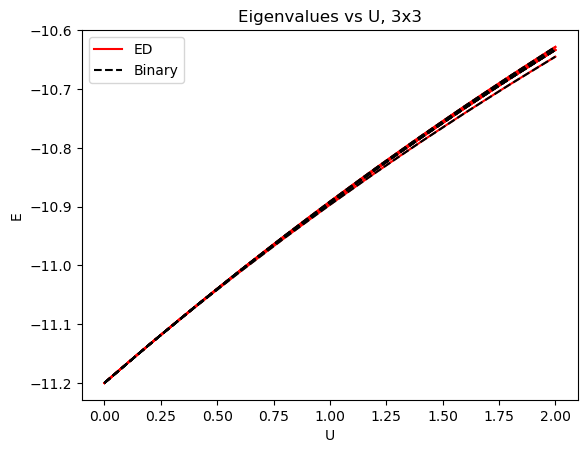

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-8.183501876146693e-09
9.11440596080837e-05
9.114405962229455e-05
9.114405962584726e-05
9.114405964005812e-05
1.3666540272794236e-06
1.366654034384851e-06


## $\Delta U = 2$

## error $ = 10^{-3}$

In [34]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [35]:
U_sweep = jnp.linspace(0, U, 2)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 8 iterations.
-10.645893977114415
Converged in 9 iterations.
-10.633482679549203
Converged in 9 iterations.
-10.63348267954919
Converged in 9 iterations.
-10.633482679549186
Converged in 9 iterations.
-10.633482679549171
Converged in 9 iterations.
-10.628783581200201
Converged in 9 iterations.
-10.628783581200194


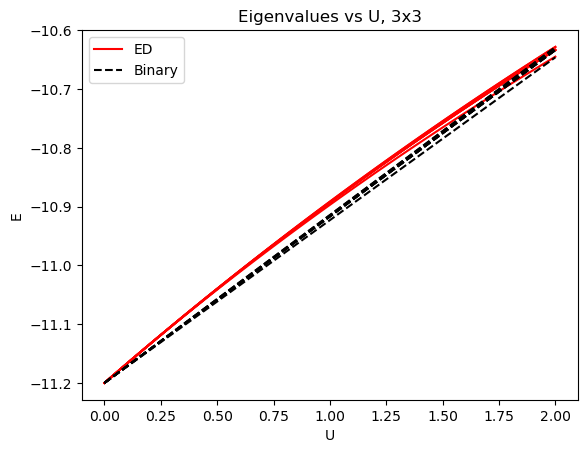

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-0.0011466705367624286
-0.0001842040798241129
-0.00018420407980990205
-0.00018420407980634934
-0.00018420407979391484
-0.0006054503968702107
-0.0006054503968648817


# Wegstien's method
### ($\Delta U = 0.2$)

## error $ = 10^{-3}$

In [39]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [40]:
U_sweep = jnp.linspace(0, U, 11)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-11.134632948439034
Converged in 1 iterations.
-11.134420539088044
Converged in 1 iterations.
-11.13442053908803
Converged in 1 iterations.
-11.134420539088024
Converged in 1 iterations.
-11.134420539088008
Converged in 1 iterations.
-11.13436311389042
Converged in 1 iterations.
-11.13436311389041
solve: 2
Converged in 1 iterations.
-11.0717711128668
Converged in 1 iterations.
-11.070976135026834
Converged in 1 iterations.
-11.07097613502682
Converged in 1 iterations.
-11.070976135026816
Converged in 1 iterations.
-11.0709761350268
Converged in 1 iterations.
-11.070750552176138
Converged in 1 iterations.
-11.070750552176131
solve: 3
Converged in 1 iterations.
-11.011281930625827
Converged in 1 iterations.
-11.00960684775034
Converged in 1 iterations.
-11.009606847750325
Converged in 1 iterations.
-11.009606847750323
Converged in 1 iterations.
-11.009606847750305
Converged in 1 iterations.
-11.009108977909396
Converged in 1 iterations.
-11.00910897790

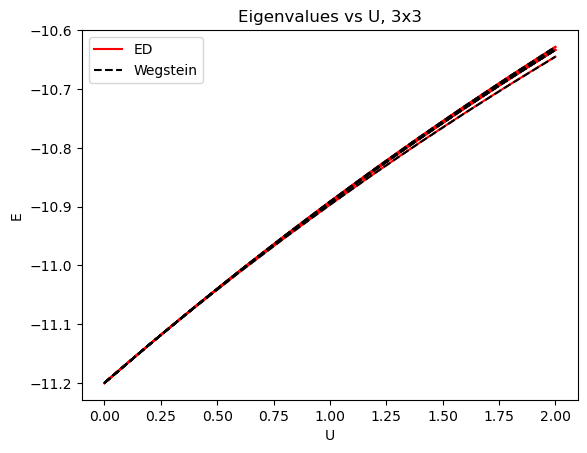

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-0.00017129517633662772
0.000308729792807938
0.0003087297928239252
0.000308729792832807
0.0003087297928416888
-0.0001030584830932213
-0.00010305848308256316


## error $ = 10^{-6}$

In [44]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [45]:
U_sweep = jnp.linspace(0, U, 11)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-11.13463316957137
Converged in 2 iterations.
-11.134424043920793
Converged in 2 iterations.
-11.134424043920925
Converged in 2 iterations.
-11.134424043920783
Converged in 2 iterations.
-11.13442404392017
Converged in 2 iterations.
-11.13436264111123
Converged in 2 iterations.
-11.134362641111329
solve: 2
Converged in 2 iterations.
-11.071771576366025
Converged in 2 iterations.
-11.070989629182632
Converged in 2 iterations.
-11.070989629182804
Converged in 2 iterations.
-11.07098962918278
Converged in 2 iterations.
-11.070989629182385
Converged in 2 iterations.
-11.070748593988002
Converged in 2 iterations.
-11.07074859398796
solve: 3
Converged in 2 iterations.
-11.011281084403075
Converged in 2 iterations.
-11.009636151019427
Converged in 2 iterations.
-11.009636151018908
Converged in 2 iterations.
-11.009636151019382
Converged in 2 iterations.
-11.009636151019503
Converged in 2 iterations.
-11.009104272460231
Converged in 2 iterations.
-11.0091042

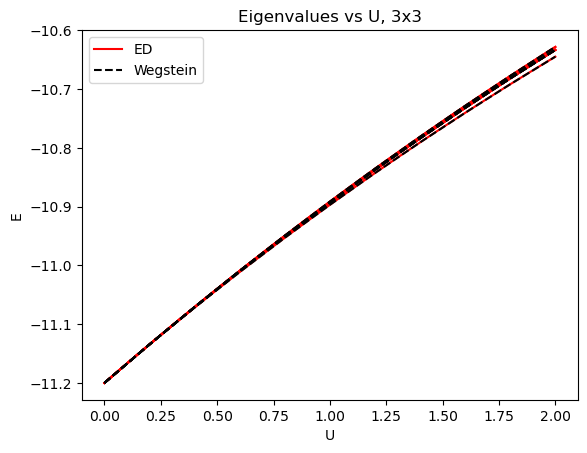

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

1.31726942242949e-07
3.767571720558749e-05
3.767571698531924e-05
3.767571663892966e-05
3.7675717241114626e-05
5.785005807723564e-07
5.785004546510208e-07


## error $ = 10^{-8}$

In [49]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [50]:
U_sweep = jnp.linspace(0, U, 11)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-11.134633172534395
Converged in 2 iterations.
-11.134424015851376
Converged in 2 iterations.
-11.134424015851465
Converged in 2 iterations.
-11.134424015852014
Converged in 2 iterations.
-11.134424015851355
Converged in 2 iterations.
-11.13436264303994
Converged in 2 iterations.
-11.134362643039657
solve: 2
Converged in 2 iterations.
-11.07177158999228
Converged in 2 iterations.
-11.070989419468427
Converged in 2 iterations.
-11.070989419468505
Converged in 2 iterations.
-11.070989419468312
Converged in 2 iterations.
-11.070989419467791
Converged in 2 iterations.
-11.070748600948486
Converged in 2 iterations.
-11.070748600948232
solve: 3
Converged in 2 iterations.
-11.011281115758214
Converged in 2 iterations.
-11.009635350501373
Converged in 2 iterations.
-11.00963535050123
Converged in 2 iterations.
-11.00963535050111
Converged in 2 iterations.
-11.009635350500938
Converged in 2 iterations.
-11.009104284111775
Converged in 2 iterations.
-11.009104

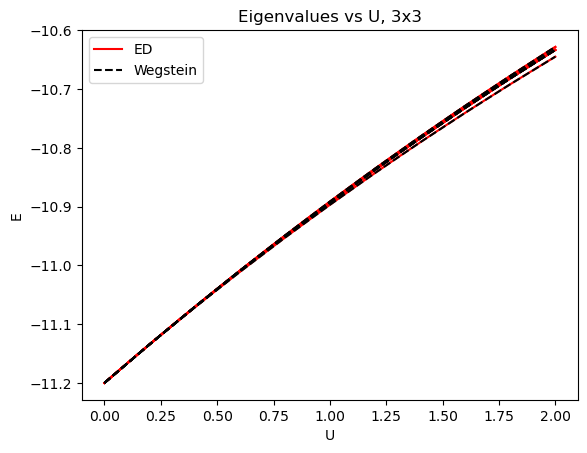

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-4.076916582107515e-11
9.115283445915168e-05
9.11532627618783e-05
9.115334985310142e-05
9.115242546009483e-05
1.3751908163328608e-06
1.376143256237583e-06


## $\Delta U = 2$

## error $ = 10^{-3}$

In [54]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [55]:
U_sweep = jnp.linspace(0, U, 2)

In [ ]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-10.644918602143381
Converged in 2 iterations.
-10.632989746081206
Converged in 2 iterations.
-10.63298974608112
Converged in 2 iterations.
-10.632989746081156
Converged in 2 iterations.
-10.632989746081112
Converged in 2 iterations.
-10.628281189623793
Converged in 2 iterations.
-10.628281189623785


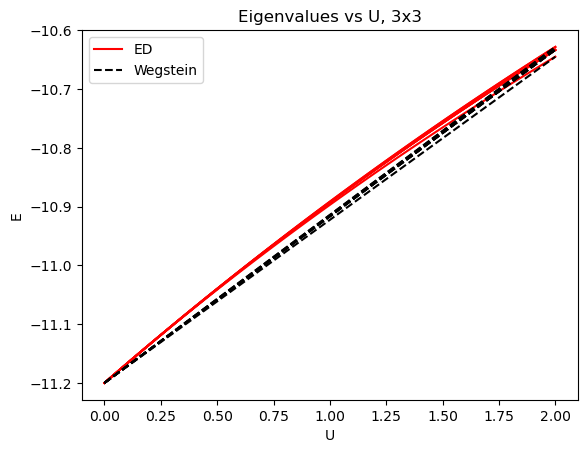

In [ ]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [ ]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-0.00017129556572825777
0.0003087293881733899
0.00030872938825865504
0.0003087293882231279
0.00030872938826576046
-0.00010305882046246495
-0.00010305882045535952
